In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
from eofs.xarray import Eof
import tensorflow as tf
import gpflow
import seaborn as sns
import cartopy.crs as ccrs
from utils import *

In [2]:
from pathlib import Path
local_data = Path("/Users/watson-parris/Local Data/ClimateBench/train_val/")

### Prepare data

In [3]:
# List of dataset to use for training
train_files = ["ssp126", "ssp370", "ssp585", "historical", "hist-GHG", "hist-aer"]

In [4]:
# Create training and testing arrays
X_train, eof_solvers = create_predictor_data(local_data, train_files)
y_train_dtr = create_predictdand_data(local_data, train_files)['diurnal_temperature_range'].values.reshape(-1, 96 * 144)

X_test = create_test_data(local_data, 'ssp245-aer', eof_solvers)
Y_test = xr.open_dataset(local_data / 'outputs_ssp245-aer.nc').compute()
dtr_truth = Y_test["diurnal_temperature_range"].mean('member')

In [6]:
# # Drop rows including nans
# nan_train_mask = X_train.isna().any(axis=1).values
# X_train = X_train.dropna(axis=0, how='any')
# y_train_dtr = y_train_dtr[~nan_train_mask]
# assert len(X_train) == len(y_train_dtr)

# nan_test_mask = X_test.isna().any(axis=1).values
# X_test = X_test.dropna(axis=0, how='any')
# dtr_truth = dtr_truth[~nan_test_mask]

In [7]:
# Standardize predictor fields requiring standardization (non-EOFs)
train_CO2_mean, train_CO2_std = X_train['CO2'].mean(), X_train['CO2'].std()
train_CH4_mean, train_CH4_std = X_train['CH4'].mean(), X_train['CH4'].std()

X_train.CO2 = (X_train.CO2 - train_CO2_mean) / train_CO2_std
X_train.CH4 = (X_train.CH4 - train_CH4_mean) / train_CH4_std

X_test.CO2 = (X_test.CO2 - train_CO2_mean) / train_CO2_std
X_test.CH4 = (X_test.CH4 - train_CH4_mean) / train_CH4_std

In [8]:
# Standardize predictand fields
train_dtr_mean, train_dtr_std = y_train_dtr.mean(), y_train_dtr.std()
y_train_dtr = (y_train_dtr - train_dtr_mean) / train_dtr_std

### Prepare model

In [9]:
# Make kernel
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

kernel_BC = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2

2022-05-06 10:20:27.477692: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
# Make model
np.random.seed(5)
mean = gpflow.mean_functions.Constant()
model = gpflow.models.GPR(data=(X_train.astype(np.float64), 
                                y_train_dtr.astype(np.float64)),
                          kernel=kernel,
                          mean_function=mean)

In [11]:
# Define optimizer
opt = gpflow.optimizers.Scipy()

# Train model
opt.minimize(model.training_loss,
             variables=model.trainable_variables,
             options=dict(disp=True, maxiter=1000))

2022-05-06 10:20:27.617917: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11344D+07    |proj g|=  2.76943D+06


 This problem is unconstrained.



At iterate    1    f=  2.90104D+06    |proj g|=  1.19454D+06

At iterate    2    f=  2.57816D+06    |proj g|=  2.39600D+05

At iterate    3    f=  2.18221D+06    |proj g|=  4.71006D+05

At iterate    4    f=  1.32338D+06    |proj g|=  2.11380D+05

At iterate    5    f=  1.23375D+06    |proj g|=  3.03710D+04

At iterate    6    f=  1.19608D+06    |proj g|=  2.24065D+04

At iterate    7    f=  1.17365D+06    |proj g|=  1.30476D+04

At iterate    8    f=  1.15458D+06    |proj g|=  5.20090D+03

At iterate    9    f=  1.15031D+06    |proj g|=  4.07267D+03

At iterate   10    f=  1.14381D+06    |proj g|=  8.52551D+03

At iterate   11    f=  1.13749D+06    |proj g|=  1.15404D+04

At iterate   12    f=  1.13508D+06    |proj g|=  3.04283D+03

At iterate   13    f=  1.12282D+06    |proj g|=  4.93327D+04

At iterate   14    f=  1.12139D+06    |proj g|=  1.99023D+04

At iterate   15    f=  1.11578D+06    |proj g|=  9.99346D+04

At iterate   16    f=  1.11322D+06    |proj g|=  6.31413D+04

At iter

      fun: 1044065.071153921
 hess_inv: <18x18 LbfgsInvHessProduct with dtype=float64>
      jac: array([   6.49965747,   10.64260895,   -2.41304695,   -8.82512295,
          0.25251692,   -7.92618817,   -4.53120569,   -0.44609434,
         20.31132786,  -45.20037067,    2.33663962,   -3.95049759,
          4.74807723,   -1.59281809,   -7.89482907,    7.01574739,
       -251.73594296,   -0.46549198])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 837
      nit: 726
     njev: 837
   status: 0
  success: True
        x: array([ 9.26091694,  1.0394202 , -0.34740942, -4.39894454, -3.69182084,
        2.2430893 ,  1.17670199, 11.10870407, -2.880174  , -3.73932872,
        6.95376229,  4.95969969, 10.23216715, 75.66135055, 18.66160465,
       -2.62829764, -2.87995104, -0.09051936])

### Predict on testing set

In [15]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.loc[2021:, :].values)
posterior_mean = standard_posterior_mean * train_dtr_std + train_dtr_mean
posterior_std = np.sqrt(standard_posterior_var) * train_dtr_std

In [16]:
# put output back into xarray format for calculating RMSE/plotting
posterior_dtr = np.reshape(posterior_mean, [80, 96, 144])
posterior_dtr_std = np.reshape(posterior_std, [80, 96, 144])

posterior_dtr_data = xr.DataArray(posterior_dtr, dims=dtr_truth.dims, coords=dtr_truth.coords)
posterior_dtr_std_data = xr.DataArray(posterior_dtr_std, dims=dtr_truth.dims, coords=dtr_truth.coords)

In [18]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(dtr_truth[35], posterior_dtr_data[35])}")
# print(f"RMSE at 2100: {get_rmse(dtr_truth[85], posterior_dtr_data[85])}")
print(f"RMSE 2045-2055: {get_rmse(dtr_truth[30:41], posterior_dtr_data[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(dtr_truth[75:], posterior_dtr_data[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(dtr_truth[35:], posterior_dtr_data[35:]).mean()}")

# RMSE for average field over last 20 years
print(f"RMSE average last 20y: {get_rmse(dtr_truth[-20:].mean(dim='time'), posterior_dtr_data[-20:].mean(dim='time'))}")

RMSE at 2050: 0.24068254861160557
RMSE 2045-2055: 0.23741282527432403
RMSE 2090-2100: 0.2585380637643647
RMSE 2050-2100: 0.24300674689604548
RMSE average last 20y: 0.10411875399228976


[Text(0.5, 1.0, 'Difference')]

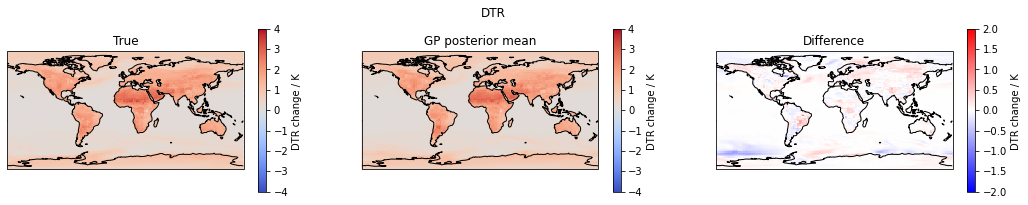

In [19]:
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## DTR
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('DTR')

# Test
plt.subplot(131, projection=proj)
dtr_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmin=-4,
                              cbar_kwargs={"label":"DTR change / K "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
posterior_dtr_data.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmin=-4,
                              cbar_kwargs={"label":"DTR change / K "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = dtr_truth - posterior_dtr_data
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"DTR change / K "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

__Feature importance__
- Really just CO2 (1.54) 

In [20]:
model

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,True,"(1,)",float64,[-0.09051936]
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.3422319912443765
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,9.261012000793814
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.012215392399113676
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.5344538702743232
GPR.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.023491944892561106
GPR.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[0.02462097, 2.34395685, 1.44542585..."
GPR.kernel.kernels[3].variance,Parameter,Softplus,,True,(),float64,0.06971379725731852
GPR.kernel.kernels[3].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[6.95471687, 4.96669024, 10.23220314..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.05461939571295061


In [21]:
# Save predictions
posterior_dtr_data.to_netcdf('climatebench-gp-posterior-mean-dtr-test-aer-2019-2100.nc')
posterior_dtr_std_data.to_netcdf('climatebench-gp-posterior-std-dtr-test-aer-2019-2100.nc')